In [1]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.append("../src")
# from analysis import GEM
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/tmp/ipykernel_23155/1425371428.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load data for every year

In [2]:
df1 = pd.read_csv(
    "../data/pct_fed_intmodel_simpleadaptations_rationing_humans.csv", comment="#"
)

for year in [1]:
    df2 = pd.read_csv(f"../results/solar+wind-NW-year{year}.csv")
    df = pd.merge(df1, df2, how="outer", left_on="country_name", right_on="country")
    df["continent"] = df["continent"].astype("category")
    color_map = {
        "Africa": "#3A913F",
        "Asia": "#6c7075",
        "Europe": "#e06234",
        "North America": "#F0B323",
        "Oceania": "#3D87CB",
        "South America": "#ec9c76",
    }
    if year == 1:
        dfkeep = df
    dfkeep[f"energy_per_capita_kWh_year{year}"] = (
        1e6 # GW to kW
        * 365.25
        * 24
        * df["total_power_baseline_GW"]
        * df["solar+wind_fraction_NW"]
        / df["population"]
        / 1e6 # population in million
    )

In [3]:
dfkeep["population_category"] = pd.cut(
    dfkeep["population"] * 1e6,
    bins=[0, 1e6, 1e7, 1e8, 1e9],
    labels=["<1M", "1M-10M", "10M-100M", ">100M"],
)

In [4]:
# drop nan country
dfkeep = dfkeep.dropna(subset=["country"])

In [5]:
# drop countries with no baseline power data or zero
dfkeep = dfkeep.dropna(subset=["total_power_baseline_GW"])
dfkeep = dfkeep[dfkeep["total_power_baseline_GW"] > 0]

In [6]:
# pct_fed cannot be >100, force to 100
dfkeep["pct_fed"] = np.minimum(dfkeep["pct_fed"], 100)

In [7]:
# Filter the DataFrame df to select only the columns that start with 'energy_per_capita_kWh_year'
df_energy = dfkeep.filter(like="energy_per_capita_kWh_year")

# Create a new DataFrame df_id_vars by dropping the columns in df_energy from the original DataFrame df
df_id_vars = dfkeep.drop(columns=df_energy.columns)

# Reshape df_energy using pd.melt
df_long = pd.melt(
    dfkeep,
    id_vars=df_id_vars.columns,
    var_name="year",
    value_name="energy_per_capita_kWh_year",
)

# Extract the year from the year column by removing the 'energy_per_capita_kWh_year' prefix
df_long["year"] = (
    df_long["year"]
    .astype(str)
    .str.replace("energy_per_capita_kWh_year", "", regex=False)
)

# # Convert the year column to numeric
df_long["year"] = pd.to_numeric(df_long["year"])
df_long["energy_per_capita_kWh_year"] = pd.to_numeric(df_long["energy_per_capita_kWh_year"])

## Make the plot

In [8]:
plt.style.use(
    "https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle"
)

/tmp/ipykernel_23155/111278906.py:5: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.swarmplot(
/tmp/ipykernel_23155/111278906.py:39: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle, label in zip(legend.legendHandles, legend.get_texts()):


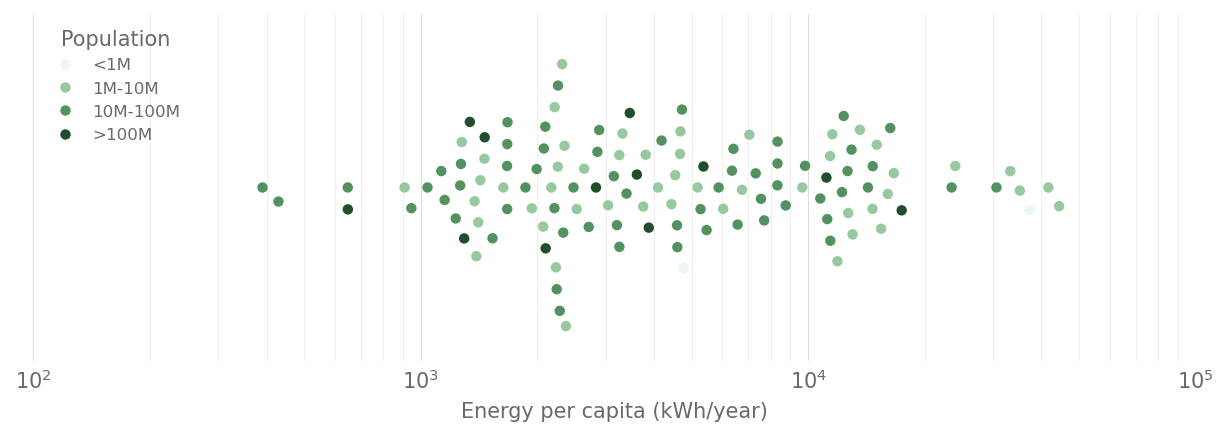

In [9]:
# Generate a cubehelix palette with discrete colors
n_colors = len(df_long["population_category"].unique())  # Number of unique categories
palette = sns.cubehelix_palette(n_colors, start=2, rot=0, dark=0, light=.95)

sns.swarmplot(
    data=dfkeep,
    x="energy_per_capita_kWh_year1",
    hue="population_category",
    size=10,
    palette=palette,
)

plt.xscale("log")
plt.xlim(100, 1e5 + 100)
plt.xlabel("Energy per capita (kWh/year)", color="dimgray")

# add minor grid
plt.grid(True, which="minor", ls="-", alpha=0.2, lw=0.5)

# make plot less tall
plt.gcf().set_size_inches(10, 3)

# remove title from legend and use smaller fonts
legend = plt.legend(
    title="Population",
    fontsize=8,
    loc="upper left",
    frameon=False,
)

# Get the figure and draw it
fig = plt.gcf()
fig.canvas.draw()

# Now get the renderer
renderer = fig.canvas.get_renderer()

# Iterate through the legend handles and labels
for handle, label in zip(legend.legendHandles, legend.get_texts()):
    # Get the original size of the marker
    orig_size = handle.get_markersize()

    # Set the marker size to a smaller value
    new_size = 5  # Adjust the new size as needed
    handle.set_markersize(new_size)

    # Recalculate the extent of the marker after resizing
    handle.draw(renderer)
    bbox = handle.get_window_extent(renderer=renderer)

    # Get the original position of the label
    orig_pos = label.get_position()
    
    # Calculate the new x position relative to the original position
    new_x = orig_pos[0] - (orig_size - new_size) / 2  

    # Adjust the text position (keep the y position unchanged)
    label.set_position((new_x, orig_pos[1])) 

In [10]:
dfkeep["sizes"] = np.sqrt(df["population"] * 1000)

In [11]:
## methane SCP
# 22 MJ/kg
scp_calories_per_kg = 22 * 239.006
# 4.4 kWh of electricity per kg of SCP
scp_kWh_per_calorie = 4.4 / scp_calories_per_kg

## cellulosic sugar
cs_kWh_per_calorie = 0

## seaweed
sw_calories_per_kg = 4000
sw_kWh_per_calorie = 19.4 / sw_calories_per_kg

## dino butter
db_calories_per_kg = 7200
db_kWh_per_calorie = 125 / db_calories_per_kg

## mushrooms
mushrooms_calories_per_kg = 310
mushrooms_kWh_per_calorie = 0.75 / mushrooms_calories_per_kg

avg_kWh_per_calorie = (scp_kWh_per_calorie + cs_kWh_per_calorie + sw_kWh_per_calorie + db_kWh_per_calorie + mushrooms_kWh_per_calorie) / 5

## curve
population_fed = np.linspace(0, 100, 100)
population_to_feed = 1 - population_fed / 100
calories_per_day_per_person_to_produce = 2100 * population_to_feed
kWh_per_day_per_person_to_produce = calories_per_day_per_person_to_produce * avg_kWh_per_calorie
kWh_per_year_per_person_to_produce = kWh_per_day_per_person_to_produce * 365.25

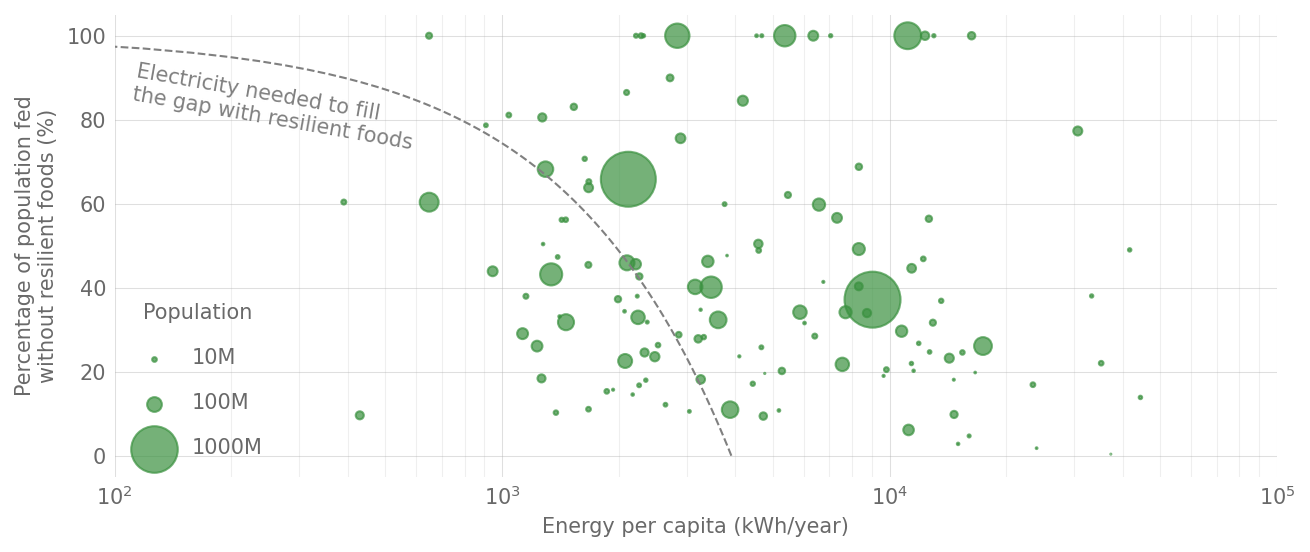

In [16]:
plt.scatter(
    dfkeep["energy_per_capita_kWh_year1"],
    dfkeep["pct_fed"],
    s=2 * dfkeep["population"],
    edgecolors=None,
    alpha=0.7,
    marker=".",
)

plt.xscale("log")
plt.xlim(100, 1e5 + 100)
plt.xlabel("Energy per capita (kWh/year)", color="dimgray")
plt.ylabel("Percentage of population fed\nwithout resilient foods (%)", color="dimgray")
plt.plot(kWh_per_year_per_person_to_produce, population_fed, color="grey", ls="--", lw=1)
plt.text(
    110,
    72,
    "Electricity needed to fill\nthe gap with resilient foods",
    color="grey",
    rotation=-10,
    va="bottom",
)

# add minor grid
plt.grid(True, which="minor", ls="-", alpha=0.2, lw=0.5)

sizes = [10, 100, 1000]
labels = ["10M", "100M", "1000M"]

handles = [
    plt.scatter(
        [], [], s=2 * s, marker=".", color="#3A913F", alpha=0.7, edgecolors=None
    )
    for s in sizes
]

# remove title from legend and use smaller fonts
legend = plt.legend(
    handles=handles,
    labels=labels,
    title="Population",
    # fontsize=8,
    loc="lower left",
    frameon=False,
    labelspacing=1.2,
)

plt.savefig("../results/energy_per_capita_vs_pct_fed.png", dpi=300, bbox_inches="tight")